In [1]:
import os
import urllib.request

file_url = "https://github.com/aswm0121/pykrx_sga/raw/refs/heads/main/Weekly_Report_Full_01_15.xlsx"
file_path = "주간동향_sgasol.xlsx"

if not os.path.exists(file_path):
    print("⚠️ 파일이 없어 다운로드합니다...")
    urllib.request.urlretrieve(file_url, file_path)

⚠️ 파일이 없어 다운로드합니다...


In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

# User-Agent 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}
sise_url = f"https://finance.naver.com/item/main.naver?code=067920"


# 최신 데이터 가져오기 (일별 시세)
response = requests.get(sise_url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

# 테이블 선택
news_fplease = soup.select("#content > div.section.new_bbs > div.sub_section.news_section > ul:nth-child(2) > li:nth-child(1) > span > a:nth-child(1)")
print(news_fplease)

[<a href="/item/news_read.naver?article_id=0003277929&amp;office_id=030&amp;code=067920&amp;sm=entity_id.basic" onclick="clickcr(this, 'dle.1', '', '1', event);">이글루코퍼레이션, '2025 이머징 A...</a>]


In [3]:
company_dic = {"SGA": "049470", "SGA솔루션즈":"184230", "안랩":"053800", "시큐브":"131090", "윈스":"136540", "이글루":"067920",
               "한컴위드":"054920", "네오리진": "094860", "케이사인":"192250", "이스트소프트":"047560", "라온시큐어": "042510","파수":"150900",
               "한국정보인증": "053300", "지란지교시큐리티":"208350","수산아이앤티":"050960", "지니언스": "263860", "드림시큐리티": "203650",
               "다우기술":"023590", "다우데이타":"032190", "한글과컴퓨터": "030520", "MDS테크":"086960", "아이티센":"124500", "콤텍시스템": "031820", "소프트센":"032680",
               "대신정보통신":"020180", "쌍용정보통신":"010280", "에스넷": "038680", "모니터랩":"434480", "파이오링크":"170790", "시큐센":"232830", "시큐레터": "418250"
               }

print(company_dic.values())

dict_values(['049470', '184230', '053800', '131090', '136540', '067920', '054920', '094860', '192250', '047560', '042510', '150900', '053300', '208350', '050960', '263860', '203650', '023590', '032190', '030520', '086960', '124500', '031820', '032680', '020180', '010280', '038680', '434480', '170790', '232830', '418250'])


## 정보 크롤링 사이트
1. 주간 코스피 지수(5일) - https://m.finance.daum.net/domestic/kosdaq,
 https://finance.naver.com/sise/sise_index.naver?code=KOSDAQ
2. 주간 일별 종가, 거래량(sga 및 경쟁사) - https://finance.naver.com/item/sise_day.naver?code=049470
3. 당일 시총 및 종가 - https://finance.naver.com/item/sise.naver?code=049470
4. 등락은 그냥 현재 - (현재-4일)하면 될 듯

### ㅁ몰루?
- 투자자별 매매동향
- 주간주요 이슈


## 1 데이터 크롤링

In [4]:
import requests as req
!pip install bs4
from bs4 import BeautifulSoup as bs


company_dict = {
    "SGA솔루션즈": "184230",
    "시큐브": "131090",
    "안랩": "053800",
    "모니터랩": "434480",
    "이스트소프트": "047560",
    "케이사인": "192250",
    "샌즈랩": "411080",
    "라온시큐어": "042510",
    "한국정보인증": "053300",
    "이글루": "067920",
    "파이오링크": "170790",
    "윈스": "136540",
    "지니언스": "263860",
    "파수": "150900",
    "한컴위드": "054920",
    "드림시큐리티": "203650",
}

### ① SGA 및 경쟁사 현재 종가, 4일 전 종가 가져오기

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


# User-Agent 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# 결과 저장 리스트
data = []

# 크롤링 시작
for company_name, stock_code in company_dict.items():
    url = f"https://finance.naver.com/item/sise_day.naver?code={stock_code}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    # 테이블 선택
    table = soup.find("table", class_="type2")
    rows = table.find_all("tr")

    # 날짜와 종가 추출
    dates = []
    prices = []
    for row in rows:
        cols = row.find_all("td")
        if len(cols) > 1:  # 유효한 데이터만 처리
            date = cols[0].get_text(strip=True)
            closing_price = cols[1].get_text(strip=True).replace(",", "")
            if date and closing_price:  # 유효한 날짜와 종가만 저장
                dates.append(date)
                prices.append(int(closing_price))
        if len(prices) >= 5:  # 상위 5개 데이터만 추출
            break

    if len(prices) >= 5:
        data.append({
            "기업명": company_name,
            f"{dates[4]} 종가": prices[4],  # 다섯 번째 날짜 (4일 전 종가)
            f"{dates[0]} 종가": prices[0],  # 첫 번째 날짜 (오늘 종가)
            "등락": prices[0]-prices[4]
        })

# 데이터프레임 생성
five_close_price_df = pd.DataFrame(data)



# 결과 출력
display(five_close_price_df)


,기업명,2025.01.24 종가,2025.02.05 종가,등락
0,SGA솔루션즈,489,507,18
1,시큐브,915,911,-4
2,안랩,71300,74800,3500
3,모니터랩,4515,4940,425
4,이스트소프트,21800,26200,4400
5,케이사인,9100,9160,60
6,샌즈랩,8170,10430,2260
7,라온시큐어,2040,2210,170
8,한국정보인증,4695,4745,50
9,이글루,5080,5130,50


In [6]:
five_close_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   기업명            16 non-null     object
 1   2025.01.24 종가  16 non-null     int64 
 2   2025.02.05 종가  16 non-null     int64 
 3   등락             16 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 644.0+ bytes


### ② SGA 및 경쟁사 현재 시총 가져오기

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


# User-Agent 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}
# 결과 저장 리스트
data = []

# 크롤링 시작
for company_name, stock_code in company_dict.items():
    url = f"https://finance.naver.com/item/main.naver?code={stock_code}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    # 테이블 선택
    sichong = soup.select("#_market_sum")
    text = sichong[0].get_text().strip()
    data.append({"회사명": company_name, "시가총액": f"{text}억"})

sichong_df = pd.DataFrame(data)
display(sichong_df)

five_close_price_df['시가총액'] = sichong_df['시가총액']
display(five_close_price_df)

,회사명,시가총액
0,SGA솔루션즈,317억
1,시큐브,388억
2,안랩,"8,323억"
3,모니터랩,605억
4,이스트소프트,"3,042억"
5,케이사인,647억
6,샌즈랩,"1,590억"
7,라온시큐어,"1,238억"
8,한국정보인증,"2,014억"
9,이글루,564억


,기업명,2025.01.24 종가,2025.02.05 종가,등락,시가총액
0,SGA솔루션즈,489,507,18,317억
1,시큐브,915,911,-4,388억
2,안랩,71300,74800,3500,"8,323억"
3,모니터랩,4515,4940,425,605억
4,이스트소프트,21800,26200,4400,"3,042억"
5,케이사인,9100,9160,60,647억
6,샌즈랩,8170,10430,2260,"1,590억"
7,라온시큐어,2040,2210,170,"1,238억"
8,한국정보인증,4695,4745,50,"2,014억"
9,이글루,5080,5130,50,564억


### ③ 5일 간 코스닥 지수 가져오기

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL 설정
url = "https://finance.naver.com/sise/sise_index_day.naver?code=KOSDAQ"

# User-Agent 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# 데이터 저장 리스트
data = []

# 요청 및 HTML 파싱
for page in range(1, 2):  # 필요한 경우 페이지를 늘릴 수 있습니다.
    response = requests.get(f"{url}&page={page}", headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    # 일별 시세 테이블 찾기
    table = soup.find("table", class_="type_1")
    rows = table.find_all("tr")

    # 데이터 파싱
    for row in rows:
        cols = row.find_all("td")
        if len(cols) > 1:  # 유효한 데이터만 처리
            date = cols[0].get_text(strip=True)
            closing_price = cols[1].get_text(strip=True).replace(",", "")
            if date and closing_price:  # 날짜와 체결가가 존재할 경우
                data.append({"날짜": date, "체결가": closing_price})
        if len(data) >= 6:  # 최근 5일 데이터만 수집
            break

# 데이터프레임 생성
kosdaq_df = pd.DataFrame(data)
kosdaq_df.drop(index=4, inplace=True)
kosdaq_df.reset_index(drop=True, inplace=True)

# 결과 출력
display(kosdaq_df)


,날짜,체결가
0,2025.02.05,730.98
1,2025.02.04,719.92
2,2025.02.03,703.80
3,2025.01.31,728.29
4,2025.01.24,728.74


In [9]:

kosdaq_df["체결가"] = pd.to_numeric(kosdaq_df["체결가"])
kosdaq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      5 non-null      object 
 1   체결가     5 non-null      float64
dtypes: float64(1), object(1)
memory usage: 212.0+ bytes


###④ SGA 5일 간 종가, 거래량

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL 설정
url = "https://finance.naver.com/item/sise_day.naver?code=184230"

# User-Agent 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# 요청 및 HTML 파싱
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

# 일별 시세 테이블 찾기
table = soup.find("table", class_="type2")
rows = table.find_all("tr")

# 데이터 저장
data = []

# 테이블 데이터 파싱
for row in rows:
    cols = row.find_all("td")
    if len(cols) > 1:  # 유효한 데이터만 처리
        date = cols[0].get_text(strip=True)
        closing_price = cols[1].get_text(strip=True).replace(",", "")
        volume = cols[6].get_text(strip=True).replace(",", "")
        if date and closing_price and volume:  # 날짜, 종가, 거래량 모두 존재할 경우
            data.append({
                "날짜": date,
                "종가": closing_price,
                "거래량": volume
            })
        if len(data) == 5:  # 최근 5일 데이터만 수집
            break

# 데이터프레임 생성
five_days_sga_cl_tr_df = pd.DataFrame(data)

# 결과 출력
display(five_days_sga_cl_tr_df)


,날짜,종가,거래량
0,2025.02.05,507,85715
1,2025.02.04,499,256459
2,2025.02.03,484,140684
3,2025.01.31,492,60081
4,2025.01.24,489,22460


In [11]:

columns_to_convert = ["종가", "거래량"]
five_days_sga_cl_tr_df[columns_to_convert] = five_days_sga_cl_tr_df[columns_to_convert].apply(pd.to_numeric)
display(five_days_sga_cl_tr_df)
five_days_sga_cl_tr_df.info()

,날짜,종가,거래량
0,2025.02.05,507,85715
1,2025.02.04,499,256459
2,2025.02.03,484,140684
3,2025.01.31,492,60081
4,2025.01.24,489,22460


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      5 non-null      object
 1   종가      5 non-null      int64 
 2   거래량     5 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 252.0+ bytes


# 2 한글폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
['NanumBarunGothic'] 11.0


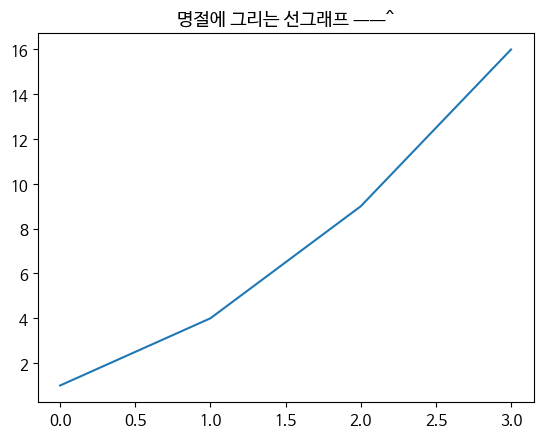

In [12]:
import matplotlib.pyplot as plt
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

plt.plot([1,4,9,16])
plt.title('명절에 그리는 선그래프 ㅡㅡ^')
plt.show()

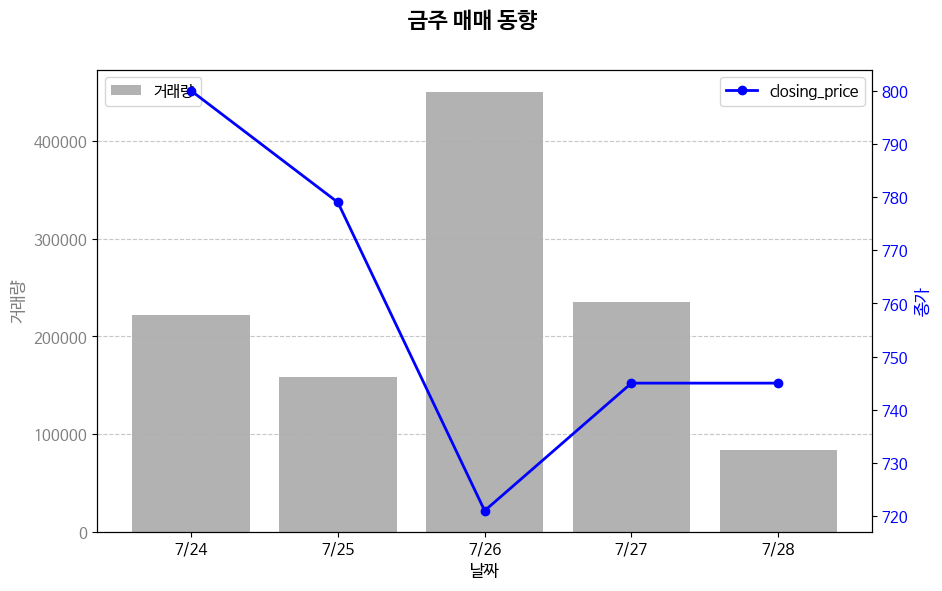

In [13]:

# **데이터 준비**
dates = ["7/24", "7/25", "7/26", "7/27", "7/28"]
closing_prices = [800, 779, 721, 745, 745]
volumes = [222095, 158140, 450484, 234938, 83439]

# **그래프 생성**
fig, ax1 = plt.subplots(figsize=(10, 6))

# **1. 막대 그래프 (거래량)**
ax1.bar(dates, volumes, color="gray", alpha=0.6, label="거래량")
ax1.set_xlabel("날짜", fontsize=12)
ax1.set_ylabel("거래량", fontsize=12, color="gray")
ax1.tick_params(axis="y", labelcolor="gray")

# **2. 꺾은선 그래프 (종가)**
ax2 = ax1.twinx()  # Y축 공유
ax2.plot(dates, closing_prices, color="blue", marker="o", linestyle="-", linewidth=2, label="closing_price")
ax2.set_ylabel("종가", fontsize=12, color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# **범례 및 제목**
fig.suptitle("금주 매매 동향", fontsize=16, weight="bold")  # 한글 제목
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# **그리드 추가**
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# **그래프 출력**
plt.show()

# 3 주간동향

### 경쟁사 주가 현황, 금주 매매동향, sga sol vs 코스닥

In [14]:
dates_1 = list(five_days_sga_cl_tr_df['날짜'])
dates_1.reverse()

In [15]:
import openpyxl
from openpyxl.styles import Alignment, Font, PatternFill

# 기존 엑셀 파일 불러오기
file_path = "주간동향_sgasol.xlsx"  # 기존 파일 경로
wb = openpyxl.load_workbook(file_path)  # 파일 불러오기

# "Weekly Report" 시트 선택
if "Weekly Report" in wb.sheetnames:
    ws = wb["Weekly Report"]  # 시트 선택
else:
    print("Sheet 'Weekly Report' not found. Creating a new one.")
    ws = wb.create_sheet("Weekly Report")  # 시트가 없으면 새로 생성

# 제목 추가
ws.merge_cells("A1:I1")
ws["A1"] = f"IR Weekly Report ({dates_1[0]} ~ {dates_1[-1]})"
ws["A1"].font = Font(size=14, bold=True, color="FFFFFF")
ws["A1"].alignment = Alignment(horizontal="center", vertical="center")
ws["A1"].fill = PatternFill(start_color="1F4E78", end_color="1F4E78", fill_type="solid")

# 1. 주간 주요 이슈
'''ws["A3"] = "주간 주요 이슈"
ws["A3"].font = Font(size=12, bold=True)
start_row = 4
for idx, issue in enumerate(weekly_issues, start=start_row):
    ws.cell(row=idx, column=1).value = f"● {issue}"
    ws.cell(row=idx, column=1).alignment = Alignment(horizontal="left", vertical="center")'''


# DataFrame 데이터를 Excel에 작성
start_row = 4
for col_idx, col_name in enumerate(five_close_price_df.columns, start=4):  # Excel 열 시작 위치 8번 (H열)
    cell = ws.cell(row=start_row, column=col_idx)
    cell.value = col_name
    cell.font = Font(bold=True)
    # cell.fill = PatternFill(start_color="BDD7EE", end_color="BDD7EE", fill_type="solid")
    cell.alignment = Alignment(horizontal="center", vertical="center")

# DataFrame 데이터를 Excel에 작성
start_row += 1  # 데이터는 컬럼명 아래부터 시작
for row_idx, row_data in enumerate(five_close_price_df.itertuples(index=False), start=start_row):
    for col_idx, value in enumerate(row_data, start=4):  # Excel 열 시작 위치 8번
        cell = ws.cell(row=row_idx, column=col_idx)
        cell.value = value
        if col_idx == 10 and isinstance(value, (int, float)) and value < 0:  # 등락 음수 빨간색
            cell.font = Font(color="FF0000")
# 2. 공시
'''ws["A8"] = "공시"
ws["A8"].font = Font(size=12, bold=True, color="000000")
start_row = 9
for idx, notice in enumerate(public_notices, start=start_row):
    ws.cell(row=idx, column=1).value = f"● {notice}"
    ws.cell(row=idx, column=1).alignment = Alignment(horizontal="left", vertical="center")'''
'''
# 3. 경쟁사 주가 현황
ws["H3"] = "경쟁사 주가 현황"
ws["H3"].font = Font(size=12, bold=True, color="000000")
start_row = 4
for row_idx, row_data in enumerate(competitor_data, start=start_row):
    for col_idx, value in enumerate(row_data, start=1):
        cell = ws.cell(row=row_idx, column=col_idx)
        cell.value = value
        if row_idx == start_row:  # 헤더 스타일 적용
            cell.font = Font(bold=True)
            cell.fill = PatternFill(start_color="BDD7EE", end_color="BDD7EE", fill_type="solid")
            cell.alignment = Alignment(horizontal="center", vertical="center")
        elif col_idx == 4 and isinstance(value, (int, float)) and value < 0:  # 등락 음수 빨간색
            cell.font = Font(color="FF0000")
'''
# 4. 금주 매매동향 데이터 작성
'''ws["A12"] = "금주 매매동향"
ws["A12"].font = Font(size=12, bold=True, color="000000")
df_start_row = 13
for idx, (date, price, volume) in enumerate(zip(stock_data["날짜"], stock_data["종가"], stock_data["거래량"]), start=df_start_row):
  ws.cell(row=idx, column=1).value = date
  ws.cell(row=idx, column=2).value = price
  ws.cell(row=idx, column=3).value = volume'''


# 5. 투자자별 매매동향
'''ws["A12"] = "[투자자별 매매동향]"
ws["A12"].font = Font(size=12, bold=True, color="000000")'''
'''start_row = 13
for idx, issue in enumerate(investor_trends, start=start_row):
    ws.cell(row=idx, column=1).value = f"● {issue}"
    ws.cell(row=idx, column=1).alignment = Alignment(horizontal="left", vertical="center")'''




'''# 5. 투자자별 매매동향
ws["A30"] = "투자자별 매매동향"
ws["A30"].font = Font(size=12, bold=True, color="000000")
start_row = 31
for idx, trend in enumerate(investor_trends, start=start_row):
    ws.cell(row=idx, column=1).value = f"● {trend}"
    ws.cell(row=idx, column=1).alignment = Alignment(horizontal="left", vertical="center")'''

# 엑셀 파일 저장
wb.save("Weekly_Report_Full.xlsx")
print("Weekly Report 생성 완료!")


Weekly Report 생성 완료!


In [16]:
'''import openpyxl
from openpyxl.styles import Alignment, Font, PatternFill
import pandas as pd




# 엑셀 워크북 생성
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Weekly Report"

# 제목 추가
ws.merge_cells("A1:L1")
ws["A1"] = f"IR Weekly Report ({dates_1[0]} ~ {dates_1[-1]})"
ws["A1"].font = Font(size=14, bold=True, color="FFFFFF")
ws["A1"].alignment = Alignment(horizontal="center", vertical="center")
ws["A1"].fill = PatternFill(start_color="1F4E78", end_color="1F4E78", fill_type="solid")

# 3. 경쟁사 주가 현황
ws["H3"] = "경쟁사 주가 현황"
ws["H3"].font = Font(size=12, bold=True, color="000000")

# DataFrame 데이터를 Excel에 작성
start_row = 4
for row_idx, row_data in enumerate(five_close_price_df.itertuples(index=False), start=start_row):
    for col_idx, value in enumerate(row_data, start=8):  # Excel 열 시작 위치 8번
        cell = ws.cell(row=row_idx, column=col_idx)
        cell.value = value
        if row_idx == start_row:  # 헤더 스타일 적용
            cell.font = Font(bold=True)
            cell.fill = PatternFill(start_color="BDD7EE", end_color="BDD7EE", fill_type="solid")
            cell.alignment = Alignment(horizontal="center", vertical="center")
        elif col_idx == 10 and isinstance(value, (int, float)) and value < 0:  # 등락 음수 빨간색
            cell.font = Font(color="FF0000")

# 엑셀 파일 저장
wb.save("Weekly_Report_Full_DataFrame.xlsx")
print("Weekly Report 생성 완료!")'''


'import openpyxl\nfrom openpyxl.styles import Alignment, Font, PatternFill\nimport pandas as pd\n\n\n\n\n# 엑셀 워크북 생성\nwb = openpyxl.Workbook()\nws = wb.active\nws.title = "Weekly Report"\n\n# 제목 추가\nws.merge_cells("A1:L1")\nws["A1"] = f"IR Weekly Report ({dates_1[0]} ~ {dates_1[-1]})"\nws["A1"].font = Font(size=14, bold=True, color="FFFFFF")\nws["A1"].alignment = Alignment(horizontal="center", vertical="center")\nws["A1"].fill = PatternFill(start_color="1F4E78", end_color="1F4E78", fill_type="solid")\n\n# 3. 경쟁사 주가 현황\nws["H3"] = "경쟁사 주가 현황"\nws["H3"].font = Font(size=12, bold=True, color="000000")\n\n# DataFrame 데이터를 Excel에 작성\nstart_row = 4\nfor row_idx, row_data in enumerate(five_close_price_df.itertuples(index=False), start=start_row):\n    for col_idx, value in enumerate(row_data, start=8):  # Excel 열 시작 위치 8번\n        cell = ws.cell(row=row_idx, column=col_idx)\n        cell.value = value\n        if row_idx == start_row:  # 헤더 스타일 적용\n            cell.font = Font(bold=True)\n   

In [17]:
dates_1 = list(five_days_sga_cl_tr_df['날짜'])
dates_1.reverse()

In [18]:
print(dates_1)

['2025.01.24', '2025.01.31', '2025.02.03', '2025.02.04', '2025.02.05']


In [19]:
five_days_sga_cl_tr_df

,날짜,종가,거래량
0,2025.02.05,507,85715
1,2025.02.04,499,256459
2,2025.02.03,484,140684
3,2025.01.31,492,60081
4,2025.01.24,489,22460


In [20]:
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
from matplotlib.ticker import FuncFormatter

# **그래프 1: 금주 매매 동향**

dates_1 = list(five_days_sga_cl_tr_df['날짜'])
dates_1.reverse()
closing_prices = list(five_days_sga_cl_tr_df['종가'])
closing_prices.reverse()
volumes = list(five_days_sga_cl_tr_df['거래량'])
volumes.reverse()


# 사용자 정의 포맷 함수
def format_volume(x, pos):
    return f"{int(x):,}"

# **그래프 생성**
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(dates_1, closing_prices, color="blue", marker="o", linestyle="-", linewidth=2, label="종가")
ax1.set_xlabel("날짜", fontsize=12)
# ax1.set_ylabel("종가", fontsize=12, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()  # Y축 공유
ax2.bar(dates_1, volumes, color="gray", alpha=0.6, label="거래량")
# ax2.set_ylabel("거래량", fontsize=12, color="gray")
ax2.tick_params(axis="y", labelcolor="gray")
# 거래량 축에 사용자 정의 포맷 적용
ax2.yaxis.set_major_formatter(FuncFormatter(format_volume))

fig.suptitle("금주 매매 동향", fontsize=16, weight="bold")  # 제목
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# **그래프 1 이미지 저장**
graph_image_1 = "graph_image_1.png"
plt.savefig(graph_image_1, bbox_inches="tight")
plt.close(fig)

# **그래프 2: SGA솔루션즈 vs 코스닥 추이**

dates_2 = list(kosdaq_df['날짜'])
dates_2.reverse()
sga = list(five_days_sga_cl_tr_df['종가'])
sga.reverse()
kosdaq = list(kosdaq_df['체결가'])
kosdaq.reverse()

# 기본 축 생성
fig, ax1 = plt.subplots(figsize=(8, 5))

# SGA솔루션즈 데이터 플롯
line1, = ax1.plot(dates_2, sga, label="SGA솔루션즈", color="teal", linestyle="-", linewidth=2)
ax1.set_xlabel("날짜", fontsize=12)

ax1.tick_params(axis='y', labelcolor="teal")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# 코스닥 데이터 플롯을 위한 두 번째 y축 생성
ax2 = ax1.twinx()
line2, = ax2.plot(dates_2, kosdaq, label="코스닥", color="orange", linestyle="--", linewidth=2)

ax2.tick_params(axis='y', labelcolor="orange")

# 두 축의 라인과 레이블을 결합하여 하나의 범례 생성
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize=10, loc="lower right")

# 제목 설정 및 레이아웃 조정
plt.title("SGA솔루션즈 vs 코스닥 추이", fontsize=14, weight="bold")
fig.tight_layout()
# 그래프 저장
graph_image_2 = "graph_image_2.png"
plt.savefig(graph_image_2, bbox_inches="tight")
plt.close()

# **엑셀 파일 열기**
excel_file_path = "Weekly_Report_Full.xlsx"  # 기존 엑셀 파일 경로
wb = load_workbook(excel_file_path)
ws = wb.active  # 기본 활성화된 워크시트 선택


# cm 단위를 픽셀로 변환
def cm_to_px(cm):
    return int(cm * 37.79527559)

# 변환된 크기
first_img_width = cm_to_px(12.86)   # 374 픽셀
first_img_height = cm_to_px(8.1) # 292 픽셀
second_img_width = cm_to_px(9.9)   # 374 픽셀
second_img_height = cm_to_px(7.86) # 292 픽셀

# **그래프 1 삽입**
img1 = Image(graph_image_1)
img1.anchor = "A22"  # 그래프 1을 삽입할 위치
img1.width = first_img_width
img1.height = first_img_height
ws.add_image(img1)

# **그래프 2 삽입**
img2 = Image(graph_image_2)
img2.anchor = "B22"  # 그래프 2를 삽입할 위치
img2.width = second_img_width
img2.height = second_img_height
ws.add_image(img2)

# **엑셀 저장**
wb.save(excel_file_path)

print(f"그래프가 {excel_file_path}에 추가되었습니다.")


그래프가 Weekly_Report_Full.xlsx에 추가되었습니다.


## 투자자 매매동향

In [21]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta

# 종목 코드 설정
stock_code = "184230"
url = "https://finance.naver.com/item/main.naver?code=184230"

# HTTP 요청 헤더 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# HTTP 요청
response = requests.get(url, headers=headers)
response.raise_for_status()  # 요청 실패 시 예외 발생

# HTML 파싱
soup = BeautifulSoup(response.text, "html.parser")

# 투자자별 매매동향 테이블 찾기
table = soup.select("#content > div.section.invest_trend > div.sub_section.right > table")  # 테이블 선택
if not table:
    raise ValueError("해당 선택자로 테이블을 찾을 수 없습니다.")

table = table[0]  # 첫 번째 테이블 선택
rows = table.find_all("tr")

d_list = []
for i in range(1,7):
  elements = soup.select(f"#content > div.section.invest_trend > div.sub_section.right > table > tbody > tr:nth-child({i}) > th")
  if elements:  # 요소가 존재하는지 확인
    d_ele = elements[0].get_text(strip=True)  # 첫 번째 요소 선택 후 텍스트 추출
    print(d_ele)
    d_list.append(d_ele)
  else:
    print("선택자로 요소를 찾을 수 없습니다.")
print(d_list)
# 데이터 추출
data = []
date_list = []
for row in rows:
    dates = row.find_all("th")
    dates = [d.get_text(strip=True) for d in dates]
    if len(dates) > 1:
      date_list.append(dates)
    cols = row.find_all("td")
    cols = [col.get_text(strip=True) for col in cols]
    if len(cols) > 1:  # 데이터가 있는 행만 처리
        data.append(cols)

print(date_list)
print(data)
data.pop()
# 데이터프레임 생성
columns = date_list[0]
for i in range(len(data)):
  data[i].insert(0, d_list[i])
df = pd.DataFrame(data, columns=columns)
df.drop(columns = ['종가', '전일비'], inplace = True)
display(df)



# CSV로 저장 (선택 사항)
df.to_csv(f"{stock_code}_investor_trends_recent.csv", index=False, encoding="utf-8-sig")



선택자로 요소를 찾을 수 없습니다.
02/05
02/04
02/03
01/31
01/24
['02/05', '02/04', '02/03', '01/31', '01/24']
[['날짜', '종가', '전일비', '외국인', '기관']]
[['507', '상향8', '+7,667', '+5,849'], ['499', '상향15', '+58,150', '-3'], ['484', '하향8', '-22,576', '+3'], ['492', '상향3', '-10,634', ''], ['489', '상향5', '-319', '-677'], ['484', '하향8', '-6,749', '+677']]


,날짜,외국인,기관
0,02/05,"+7,667","+5,849"
1,02/04,"+58,150",-3
2,02/03,"-22,576",+3
3,01/31,"-10,634",
4,01/24,-319,-677


In [22]:
date_list

[['날짜', '종가', '전일비', '외국인', '기관']]

In [23]:
import openpyxl
from openpyxl.styles import Alignment, Font, PatternFill

# 기존 엑셀 파일 불러오기
file_path = "/content/Weekly_Report_Full.xlsx"  # 기존 파일 경로
wb = openpyxl.load_workbook(file_path)  # 파일 불러오기

# "Weekly Report" 시트 선택
if "Weekly Report" in wb.sheetnames:
    ws = wb["Weekly Report"]  # 시트 선택
else:
    print("Sheet 'Weekly Report' not found. Creating a new one.")
    ws = wb.create_sheet("Weekly Report")  # 시트가 없으면 새로 생성

# DataFrame 데이터를 Excel에 작성
start_row = 24
for col_idx, col_name in enumerate(df.columns, start=6):  # Excel 열 시작 위치 8번 (H열)
    cell = ws.cell(row=start_row, column=col_idx)
    cell.value = col_name
    cell.font = Font(bold=True)
    # cell.fill = PatternFill(start_color="BDD7EE", end_color="BDD7EE", fill_type="solid")
    cell.alignment = Alignment(horizontal="center", vertical="center")

# DataFrame 데이터를 Excel에 작성
start_row += 1  # 데이터는 컬럼명 아래부터 시작
for row_idx, row_data in enumerate(df.itertuples(index=False), start=start_row):
    for col_idx, value in enumerate(row_data, start=6):  # Excel 열 시작 위치 8번
        cell = ws.cell(row=row_idx, column=col_idx)
        if len(value) > 0 and value[0] == '+':
          value = value[1:] + " 매수"
          cell.font = Font(color = "FF0000")
        elif len(value) > 0 and value[0] == '-':
          value = value[1:] + " 매도"
          cell.font = Font(color = "0000FF")
        elif value == '':
          value = '-'
          cell.font = Font(color = "0000FF")
        cell.value = value


wb.save("Weekly_Report_Full.xlsx")
print("Weekly Report 생성 완료!")

Weekly Report 생성 완료!


### 공시
- SGA솔루션즈
- corp_code = 00988364

In [24]:
import pandas as pd
import requests
from datetime import datetime, timedelta

# API 인증키와 고유번호 리스트
api_key = "ff12d16bfd2cb5ddef36494b71c419fda68b304d"  # 자신의 OpenDART API 키 입력
corp_code = "00988364"

# 공시 데이터를 저장할 리스트
latest_disclosures = []

# OpenDART API URL
url_json = "https://opendart.fss.or.kr/api/list.json"

# 오늘 날짜를 YYYYMMDD 형식으로 가져오기
end_date = datetime.today()
start_date = end_date - timedelta(days=4)  # 5일 전 시작 날짜

# 기업 공시 데이터를 조회
for day_offset in range(5):
    query_date = (start_date + timedelta(days=day_offset)).strftime('%Y%m%d')
    print(f"Querying for date: {query_date}")

    params = {
        'crtfc_key': api_key,
        'corp_code': corp_code,
        'bgn_de': query_date,  # 조회 시작 날짜
        'end_de': query_date   # 조회 종료 날짜
    }

    response = requests.get(url_json, params=params)
    response.encoding = 'utf-8'  # 응답 인코딩을 UTF-8로 설정
    res = response.json()


    # 공시 데이터가 없는 경우 처리
    if res['status'] == '013':  # 공시 데이터 없음
        print(f"{corp_code}: {query_date} 공시 데이터 없음")
        latest_disclosures.append({
            '날짜': query_date,
            'corp_code': corp_code,
            '공시 제목': '공시 없음',
            '공시 URL': ''
        })

    # 공시 데이터가 있을 경우
    elif 'list' in res:
        for disclosure in res['list']:
            title = disclosure['report_nm']
            url = f"https://dart.fss.or.kr/dsaf001/main.do?rcpNo={disclosure['rcept_no']}"
            latest_disclosures.append({
                '날짜': query_date,
                'corp_code': corp_code,
                '공시 제목': title,
                '공시 URL': url
            })
    else:
        print(f"{corp_code}: {query_date} 공시 리스트 없음")
        latest_disclosures.append({
            '날짜': query_date,
            'corp_code': corp_code,
            '공시 제목': '공시 없음',
            '공시 URL': ''
        })

# 결과를 데이터프레임으로 변환
df_latest_disclosures = pd.DataFrame(latest_disclosures)
df_latest_disclosures = df_latest_disclosures[df_latest_disclosures['공시 제목'] != '공시 없음']
df_latest_disclosures  = df_latest_disclosures[['날짜', '공시 제목', '공시 URL']]
display(df_latest_disclosures)

Querying for date: 20250201
00988364: 20250201 공시 데이터 없음
Querying for date: 20250202
00988364: 20250202 공시 데이터 없음
Querying for date: 20250203
00988364: 20250203 공시 데이터 없음
Querying for date: 20250204
00988364: 20250204 공시 데이터 없음
Querying for date: 20250205
00988364: 20250205 공시 데이터 없음


,날짜,공시 제목,공시 URL


In [25]:
df_latest_disclosures.empty

True

In [26]:
if not df_latest_disclosures.empty:
  import pandas as pd
  from openpyxl import load_workbook
  from openpyxl.styles import Font

  # 기존 엑셀 파일 경로
  file_path = "/content/Weekly_Report_Full.xlsx"
  output_path = "/content/Weekly_Report_Full.xlsx"

  # 엑셀 파일 불러오기
  wb = load_workbook(file_path)

  # 작업용2 시트 가져오기 (없으면 생성)
  if "Weekly Report" in wb.sheetnames:
      ws = wb["Weekly Report"]
  else:
      ws = wb.create_sheet("Weekly Report")

  # 데이터 추가 시작 셀
  start_row = 18  # 데이터 시작 행 번호
  start_col = 1  # 데이터 시작 열 번호

  # 현재 입력할 행 번호
  current_row = start_row

  # 데이터 추가
  for row_idx, row in df_latest_disclosures.iterrows():
      excel_row_number = current_row


      # 공시 제목 셀 추가 및 하이퍼링크 처리
      title_cell = ws.cell(row=current_row, column=start_col, value = row['공시 제목'] + " " + "(" + row['날짜']+ ")")
      title_cell.hyperlink = row['공시 URL']
      title_cell.font = Font(color="0000FF", underline="single")

      # 다음 행으로 이동
      current_row += 1

  # 엑셀 파일 저장
  wb.save(output_path)
  print(f"데이터프레임이 {output_path} 파일에 성공적으로 추가되었습니다.")

## 주간 주요 이슈

In [27]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from urllib.parse import urlparse, parse_qs
from datetime import datetime, timedelta

# User-Agent 설정
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# 오늘 날짜 가져오기
today = datetime.today()
print(f"오늘은 {today.strftime('%y/%m/%d')}입니다")

# 7일 전 날짜 계산
seven_days_ago = today - timedelta(days=5)

# 결과 저장 리스트
all_data = []

# 회사별 최신 시세 데이터 크롤링
for company_name, stock_code in company_dic.items():
    url = f"https://finance.naver.com/item/main.naver?code={stock_code}"

    # 최신 데이터 가져오기 (일별 시세)
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    news_items = soup.select('#content .news_section ul li')
    # print(news_items)

    company_news = []
    i = 1

    for news in news_items:
        # 기사 제목과 URL 추출

        news_title = news.select_one('span > a').get_text()
        news_url = news.select_one('span > a')['href']

        # 뉴스 날짜 확인
        print(f"i는 {i}")
        news_date_text = soup.select_one(f'#content > div.section.new_bbs > div.sub_section.news_section > ul:nth-child(2) > li:nth-child({i}) > em').get_text().strip()
        i = i+1
        if int(news_date_text[:2]) > 1:
          news_date_text = "24/"+news_date_text
        else:
          news_date_text = "25/"+news_date_text
        news_date = datetime.strptime(news_date_text, '%y/%m/%d')
        print(f"뉴스의 날짜는 {news_date}, 5일 전 날짜는 {seven_days_ago}입니다")
        print(news_date >=seven_days_ago )
        if news_date >= seven_days_ago:
            # URL 파싱 및 정리
            parsed_url = urlparse(news_url)
            query_params = parse_qs(parsed_url.query)
            article_id = query_params.get("article_id", [None])[0]
            office_id = query_params.get("office_id", [None])[0]
            if article_id and office_id:
                news_url = f"https://n.news.naver.com/mnews/article/{office_id}/{article_id}"

            print(f'회사명: {company_name}')
            print(f'기사 제목: {news_title}')
            print(f'기사 URL: {news_url}')
            print(f'기사 날짜: {news_date.strftime("%Y-%m-%d %H:%M")}\n')

            # 데이터 저장
            company_news.append({
                "회사명": company_name,
                "제목": news_title,
                "url": news_url,
                "날짜": news_date.strftime("%Y-%m-%d %H:%M")
            })

    if not company_news:
        print(f"{company_name}: 최근 5일 내 뉴스가 없습니다.\n")
        all_data.append({
            "회사명": company_name,
            "제목": "뉴스 없음",
            "url": "",
            "날짜": ""
        })
    else:
        all_data.extend(company_news)

# DataFrame 생성
df = pd.DataFrame(all_data)

# CSV와 Excel 저장
df.to_csv("latest_news_of_companies.csv", index=False, encoding="utf-8-sig")
df.to_excel("latest_news_of_companies.xlsx", index=False, engine="openpyxl")
print("데이터가 성공적으로 저장되었습니다.")


오늘은 25/02/05입니다
i는 1
뉴스의 날짜는 2025-01-06 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 2
뉴스의 날짜는 2024-12-16 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 3
뉴스의 날짜는 2024-12-04 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 4
뉴스의 날짜는 2024-11-26 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 5
뉴스의 날짜는 2024-11-25 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
SGA: 최근 5일 내 뉴스가 없습니다.

i는 1
뉴스의 날짜는 2025-01-31 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 2
뉴스의 날짜는 2025-01-09 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 3
뉴스의 날짜는 2025-01-08 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 4
뉴스의 날짜는 2025-01-07 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 5
뉴스의 날짜는 2025-01-06 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
SGA솔루션즈: 최근 5일 내 뉴스가 없습니다.

i는 1
뉴스의 날짜는 2024-02-04 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.614283입니다
False
i는 2
뉴스의 날짜는 2024-02-03 00:00:00, 5일 전 날짜는 2025-01-31 10:06:22.

In [28]:
df = df[df['제목'] != "뉴스 없음"]

In [29]:
pd.set_option('display.max_rows', None)
df

,회사명,제목,url,날짜


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회사명     0 non-null      object
 1   제목      0 non-null      object
 2   url     0 non-null      object
 3   날짜      0 non-null      object
dtypes: object(4)
memory usage: 0.0+ bytes


In [31]:
dfc = df.copy()
dfc.drop_duplicates(subset=['회사명', '날짜'], keep='first', inplace=True)
dfc.drop_duplicates(subset=['회사명'], keep='first', inplace=True)
# dfc=dfc.iloc[:5]
# 결과 출력
display(dfc)
dfc.info()

,회사명,제목,url,날짜


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회사명     0 non-null      object
 1   제목      0 non-null      object
 2   url     0 non-null      object
 3   날짜      0 non-null      object
dtypes: object(4)
memory usage: 0.0+ bytes


In [32]:


# '중요 내용' 컬럼을 빈 값으로 초기화
dfc['중요 내용'] = None

# 본문 내용을 추출하는 함수 정의
def extract_important_content(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        content = soup.select_one('#dic_area > strong')
        # #dic_area > b
        return content.get_text(strip=True) if content else '내용 없음'
    except Exception as e:
        return f'오류 발생: {e}'

# 각 URL에 대해 본문 내용 추출 및 데이터프레임 업데이트
if 'url' in dfc.columns:
    dfc['중요 내용'] = dfc['url'].apply(lambda x: extract_important_content(x) if pd.notna(x) and x else 'URL 없음')
else:
    print("'url' 컬럼이 데이터프레임에 존재하지 않습니다.")

# 결과 출력
display(dfc)


,회사명,제목,url,날짜,중요 내용


In [33]:
# '제목' 컬럼을 빈 값으로 초기화
dfc['full_제목'] = None

# 본문 내용을 추출하는 함수 정의
def extract_full_name(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        content = soup.select_one('#title_area > span')
        # #dic_area > b
        return content.get_text(strip=True) if content else '제목 없음'
    except Exception as e:
        return f'오류 발생: {e}'

# 각 URL에 대해 본문 내용 추출 및 데이터프레임 업데이트
if 'url' in dfc.columns:
    dfc['full_제목'] = dfc['url'].apply(lambda x: extract_full_name(x) if pd.notna(x) and x else 'URL 없음')
else:
    print("'url' 컬럼이 데이터프레임에 존재하지 않습니다.")

# 결과 출력
display(dfc)

,회사명,제목,url,날짜,중요 내용,full_제목


In [34]:
dfc = dfc[(dfc['중요 내용'] != '내용 없음') & (dfc['중요 내용'].str.len() > 13) & (dfc['full_제목'] != '제목 없음')][['회사명', '제목', '중요 내용', 'full_제목']]
display(dfc)
print("====================================================================")
df_length = len(dfc)
if df_length >= 7:
  dfc = dfc.iloc[:7]
dfc['제목'] = dfc['full_제목']
dfc.drop(columns = ['full_제목'], inplace= True)
display(dfc)

,회사명,제목,중요 내용,full_제목


,회사명,제목,중요 내용


In [35]:
dfc = dfc[['제목', '중요 내용']]

In [36]:
from datetime import datetime

# 현재 날짜와 시간 가져오기
now = datetime.now()

# 연-월-일 형식으로 포맷팅
formatted_date = now.strftime("%Y-%m-%d")
print("현재 날짜:", formatted_date)

현재 날짜: 2025-02-05


In [37]:
import openpyxl
from openpyxl.styles import Alignment, Font, PatternFill

# 기존 엑셀 파일 불러오기
file_path = "/content/Weekly_Report_Full.xlsx"  # 기존 파일 경로
wb = openpyxl.load_workbook(file_path)  # 파일 불러오기


# "Weekly Report" 시트 선택
if "Weekly Report" in wb.sheetnames:
    ws = wb["Weekly Report"]  # 시트 선택
else:
    print("Sheet 'Weekly Report' not found. Creating a new one.")
    ws = wb.create_sheet("Weekly Report")  # 시트가 없으면 새로 생성

start_row = 4


name_job_dict_zip = dict(zip(dfc['제목'], dfc['중요 내용']))
for i in range(len(name_job_dict_zip.keys())):
  if i+start_row >= 16: break
  cell = ws.cell(row = i+start_row, column = 1)
  cell.font = Font(bold=True, color = "006400", size = 12.5)
  cell.value = "· " + list(name_job_dict_zip.keys())[i]
  start_row += 1
  if i+start_row >= 16: break
  cell = ws.cell(row = i+start_row, column = 1)
  cell.font = Font(bold=False, color = "808080", size = 11)
  value = "(" +  name_job_dict_zip[list(name_job_dict_zip.keys())[i]] + ")"
  if len(value) > 40:
    cell.value = value[:40]
    start_row += 1
    if i+start_row >= 16: break
    cell = ws.cell(row = i+start_row, column = 1)
    cell.font = Font(bold=False, color = "808080", size = 11)
    cell.value = value[40:]
  else:
    cell.value = value
  # start_row += 1


'''         if row_idx == start_row:  # 헤더 스타일 적용
            cell.font = Font(bold=True)
            cell.fill = PatternFill(start_color="BDD7EE", end_color="BDD7EE", fill_type="solid")
            cell.alignment = Alignment(horizontal="center", vertical="center")
        elif col_idx == 10 and isinstance(value, (int, float)) and value < 0:  # 등락 음수 빨간색
            cell.font = Font(color="FF0000")'''

'''for row_idx, row_data in enumerate(dfc.itertuples(index=False), start=start_row):
    print(row_idx)
    for col_idx, value in enumerate(row_data, start=1):  # Excel 열 시작 위치 8번
        print(col_idx, value)
        if (col_idx == 2):
          row_idx = row_idx+1
          col_idx = 1
        cell = ws.cell(row=row_idx, column=col_idx)
        cell.value = value'''





# 엑셀 파일 저장
output_path = f"<완>weekly_report_SGASOL_{formatted_date}.xlsx"
wb.save(output_path)
print(f"{output_path} 생성 완료!")

<완>weekly_report_SGASOL_2025-02-05.xlsx 생성 완료!


## PBR

In [38]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 16.9 MB/s eta 0:00:00


In [39]:
from pykrx import stock
import pandas as pd
from datetime import datetime, timedelta

# ✅ 기업명과 종목코드를 포함한 딕셔너리
company_dic = {
    "SGA": "049470", "SGA솔루션즈": "184230", "안랩": "053800", "시큐브": "131090", "윈스": "136540", "이글루": "067920",
    "한컴위드": "054920", "네오리진": "094860", "케이사인": "192250", "이스트소프트": "047560", "라온시큐어": "042510", "파수": "150900",
    "한국정보인증": "053300", "지란지교시큐리티": "208350", "수산아이앤티": "050960", "지니언스": "263860", "드림시큐리티": "203650",
    "다우기술": "023590", "다우데이타": "032190", "한글과컴퓨터": "030520", "MDS테크": "086960", "아이티센": "124500",
    "콤텍시스템": "031820", "소프트센": "032680", "대신정보통신": "020180", "쌍용정보통신": "010280", "에스넷": "038680",
    "모니터랩": "434480", "파이오링크": "170790", "시큐센": "232830", "시큐레터": "418250"
}


company_list = [
    "SGA솔루션즈", "시큐브", "안랩", "모니터랩", "이스트소프트", "케이사인", "샌즈랩",
    "라온시큐어", "한국정보인증", "이글루", "파이오링크", "윈스", "지니언스",
    "파수", "한컴위드", "드림시큐리티"
]

company_dic = {company: code for company, code in company_dic.items() if company in company_list}

# ✅ 오늘 날짜와 7일 전 날짜 계산
today = datetime.today().strftime("%Y%m%d")
one_week_ago = (datetime.today() - timedelta(days=365)).strftime("%Y%m%d")

# ✅ 결과 저장할 딕셔너리 (기업별 데이터를 날짜별 컬럼으로 정리)
data_list = []

# ✅ 모든 종목에 대해 데이터 가져오기
for company, code in company_dic.items():
    df_price = stock.get_market_fundamental(one_week_ago, today, code, freq="m")

    if not df_price.empty:
        df_price.reset_index(inplace=True)  # 날짜를 컬럼으로 변환
        df_price.insert(0, "회사명", company)  # 회사명 추가
        df_price.insert(1, "종목코드", code)  # 종목코드 추가
        data_list.append(df_price)  # 리스트에 추가

# ✅ 데이터프레임 생성 (각 기업별 데이터 합치기)
df_final = pd.concat(data_list, ignore_index=True)

# ✅ CSV 저장
df_final.to_csv("stock_data_last_7_days.csv", encoding="utf-8-sig", index=False)

# ✅ 데이터프레임 확인
display(df_final.head())


/usr/local/lib/python3.11/dist-packages/pykrx/stock/stock_api.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').apply(how)
/usr/local/lib/python3.11/dist-packages/pykrx/stock/stock_api.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').apply(how)
/usr/local/lib/python3.11/dist-packages/pykrx/stock/stock_api.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').apply(how)
/usr/local/lib/python3.11/dist-packages/pykrx/stock/stock_api.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').apply(how)
/usr/local/lib/python3.11/dist-packages/pykrx/stock/stock_api.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('

,회사명,종목코드,날짜,BPS,PER,PBR,EPS,DIV,DPS
0,SGA솔루션즈,184230,2024-02-29,865,8.53,0.85,86,0.0,0
1,SGA솔루션즈,184230,2024-03-31,865,8.28,0.82,86,0.0,0
2,SGA솔루션즈,184230,2024-04-30,865,8.56,0.85,86,0.0,0
3,SGA솔루션즈,184230,2024-05-31,861,0.00,0.81,0,0.0,0
4,SGA솔루션즈,184230,2024-06-30,861,0.00,0.75,0,0.0,0


In [40]:
df_final.columns

Index(['회사명', '종목코드', '날짜', 'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'], dtype='object')

In [41]:
# ✅ 회사명을 기준으로 groupby 적용

# ✅ 피벗 테이블 생성
table = pd.pivot_table(df_final, index=['회사명', '날짜'], values=['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'])

# ✅ 회사명 순서를 company_dic의 키 순서대로 정렬
company_order = list(company_dic.keys())  # company_dic의 키 순서 리스트

# ✅ 정렬을 위한 매핑 딕셔너리 생성
sort_mapping = {name: i for i, name in enumerate(company_order)}

# ✅ 회사명을 해당 순서대로 정렬
table = table.sort_index(level='회사명', key=lambda x: x.map(sort_mapping))

display(table)
table.info()

BPS   DIV     DPS     EPS   PBR    PER
회사명     날짜                                                    
SGA솔루션즈 2024-02-29    865.0  0.00     0.0    86.0  0.85   8.53
        2024-03-31    865.0  0.00     0.0    86.0  0.82   8.28
        2024-04-30    865.0  0.00     0.0    86.0  0.85   8.56
        2024-05-31    861.0  0.00     0.0     0.0  0.81   0.00
        2024-06-30    861.0  0.00     0.0     0.0  0.75   0.00
        2024-07-31    861.0  0.00     0.0     0.0  0.70   0.00
        2024-08-31    861.0  0.00     0.0     0.0  0.63   0.00
        2024-09-30    861.0  0.00     0.0     0.0  0.61   0.00
        2024-10-31    861.0  0.00     0.0     0.0  0.60   0.00
        2024-11-30    861.0  0.00     0.0     0.0  0.58   0.00
        2024-12-31    861.0  0.00     0.0     0.0  0.57   0.00
        2025-01-31    819.0  0.00     0.0     0.0  0.57   0.00
        2025-02-28    819.0  0.00     0.0     0.0  0.59   0.00
안랩      2024-02-29  29416.0  1.58  1100.0  1631.0  2.37  42.73
        2024-03-31  29416.0  1.55  1100.0  1631.0  2.41  43.47
        2024-04-30  29416.0  1.60  1100.0  1631.0  2.34  42.12
        2024-05-31  32433.0  2.04  1300.0  4125.0  1.96  15.42
        2024-06-30  32433.0  2.05  1300.0  4125.0  1.96  15.39
        2024-07-31  32433.0  2.15  1300.0  4125.0  1.87  14.69
        2024-08-31  32433.0  2.26  1300.0  4125.0  1.78  13.96
        2024-09-30  32433.0  2.42  1300.0  4125.0  1.66  13.02
        2024-10-31  32433.0  2.40  1300.0  4125.0  1.67  13.12
        2024-11-30  32433.0  2.29  1300.0  4125.0  1.75  13.75
        2024-12-31  32433.0  2.12  1300.0  4125.0  1.89  14.84
        2025-01-31  32433.0  1.89  1300.0  4125.0  2.12  16.65
        2025-02-28  32433.0  1.72  1300.0  4125.0  2.33  18.33
시큐브     2024-02-29   1018.0  2.50    25.0   118.0  0.98   8.47
        2024-03-31   1018.0  2.60    25.0   118.0  0.95   8.16
        2024-04-30   1018.0  2.53    25.0   118.0  0.97   8.38
        2024-05-31   1138.0  2.61    25.0   143.0  0.84   6.70
        2024-06-30   1138.0  2.70    25.0   143.0  0.81   6.48
        2024-07-31   1138.0  2.91    25.0   143.0  0.75   6.00
        2024-08-31   1138.0  2.83    25.0   143.0  0.78   6.17
        2024-09-30   1138.0  2.86    25.0   143.0  0.77   6.10
        2024-10-31   1138.0  2.89    25.0   143.0  0.76   6.06
        2024-11-30   1138.0  2.85    25.0   143.0  0.77   6.14
        2024-12-31   1138.0  2.84    25.0   143.0  0.77   6.16
        2025-01-31   1138.0  2.98    25.0   143.0  0.74   5.87
        2025-02-28   1138.0  2.76    25.0   143.0  0.80   6.33
윈스      2024-02-29  13734.0  3.88   500.0  1537.0  0.94   8.39
        2024-03-31  13734.0  3.90   500.0  1537.0  0.93   8.34
        2024-04-30  13734.0  3.89   500.0  1537.0  0.93   8.35
        2024-05-31  14933.0  4.00   500.0  1681.0  0.84   7.44
        2024-06-30  14933.0  3.81   500.0  1681.0  0.88   7.81
        2024-07-31  14933.0  3.50   500.0  1681.0  0.96   8.49
        2024-08-31  14933.0  3.73   500.0  1681.0  0.90   7.98
        2024-09-30  14933.0  3.86   500.0  1681.0  0.87   7.72
        2024-10-31  14933.0  3.92   500.0  1681.0  0.85   7.58
        2024-11-30  14933.0  3.88   500.0  1681.0  0.86   7.66
        2024-12-31  14933.0  3.92   500.0  1681.0  0.86   7.60
        2025-01-31  14933.0  4.02   500.0  1681.0  0.83   7.39
        2025-02-28  14933.0  4.57   500.0  1681.0  0.73   6.50
이글루     2024-02-29   6660.0  2.74   180.0   692.0  0.98   9.48
        2024-03-31   6660.0  2.72   180.0   692.0  0.99   9.57
        2024-04-30   6660.0  2.75   180.0   692.0  0.98   9.45
        2024-05-31   7291.0  2.83   180.0   835.0  0.87   7.60
        2024-06-30   7291.0  3.18   180.0   835.0  0.78   6.78
        2024-07-31   7291.0  3.08   180.0   835.0  0.80   6.99
        2024-08-31   7291.0  3.27   180.0   835.0  0.75   6.59
        2024-09-30   7291.0  3.49   180.0   835.0  0.71   6.18
        2024-10-31   7291.0  3.50   180.0   835.0  0.70   6.16
        2024-11-30   7291.0  3.56   180.0   835.0  0.69

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 195 entries, ('SGA솔루션즈', Timestamp('2024-02-29 00:00:00')) to ('파이오링크', Timestamp('2025-02-28 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BPS     195 non-null    float64
 1   DIV     195 non-null    float32
 2   DPS     195 non-null    float64
 3   EPS     195 non-null    float64
 4   PBR     195 non-null    float32
 5   PER     195 non-null    float64
dtypes: float32(2), float64(4)
memory usage: 8.9+ KB


In [42]:
# import yfinance as yf
# import pandas as pd
# import time
# from openpyxl import load_workbook

# # ✅ 실시간 주식 데이터를 가져오는 함수
# def get_stock_data(ticker):
#     stock = yf.Ticker(ticker)
#     data = stock.history(period="1d", interval="1m")  # 1분 단위 데이터 가져오기
#     latest_data = data.iloc[-1]  # 가장 최신 데이터
#     return latest_data.name, latest_data['Open'], latest_data['High'], latest_data['Low'], latest_data['Close'], latest_data['Volume']

# # ✅ 엑셀 업데이트 함수
# def update_excel(ticker, excel_path):
#     # 기존 엑셀 파일 불러오기 (없으면 새로 생성)
#     try:
#         wb = load_workbook(excel_path)
#         ws = wb.active
#     except FileNotFoundError:
#         wb = Workbook()
#         ws = wb.active
#         ws.append(["Timestamp", "Open", "High", "Low", "Close", "Volume"])  # 헤더 추가

#     # 주식 데이터 가져오기
#     timestamp, open_price, high, low, close, volume = get_stock_data(ticker)

#     # 엑셀에 데이터 추가
#     ws.append([timestamp, open_price, high, low, close, volume])
#     wb.save(excel_path)
#     print(f"✅ {ticker} 주식 데이터 업데이트 완료: {timestamp}")

# # ✅ 실시간으로 업데이트 실행
# excel_path = "realtime_stock.xlsx"
# ticker = "AAPL"  # 원하는 주식 티커 (애플 예제)

# while True:
#     update_excel(ticker, excel_path)  # 엑셀 업데이트
#     time.sleep(60)  # 60초마다 업데이트 (1분 단위)


<ipython-input-43-0ce305ef4474>:28: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


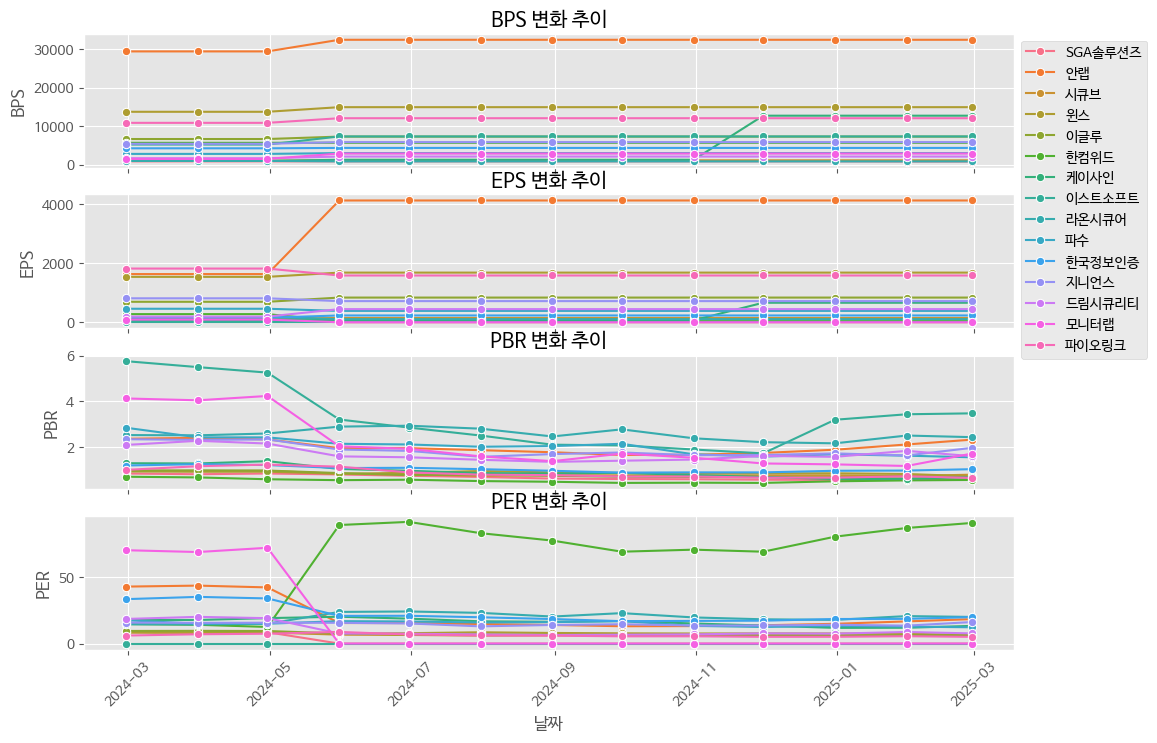

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ 데이터프레임 불러오기 (df가 기존의 피벗 테이블 형태로 되어 있다고 가정)
df_plot = table.reset_index()  # 인덱스를 컬럼으로 변환

# ✅ 그래프 스타일 설정
plt.style.use("ggplot")

# ✅ 시각화할 지표 선택 (BPS, EPS, PBR, PER)
metrics = ["BPS", "EPS", "PBR", "PER"]

# ✅ 각 회사별로 그래프를 생성 (멀티 서브플롯)
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 8), sharex=True)

for idx, metric in enumerate(metrics):
    sns.lineplot(data=df_plot, x="날짜", y=metric, hue="회사명", ax=axes[idx], marker="o")
    axes[idx].set_title(f"{metric} 변화 추이")
    axes[idx].set_ylabel(metric)

    if idx == 0:
        axes[idx].legend(loc="upper left", bbox_to_anchor=(1, 1))  # 첫 번째 그래프에만 범례 표시
    else:
        axes[idx].get_legend().remove()  # 나머지 그래프에서는 범례 제거

plt.xticks(rotation=45)  # 날짜 라벨 회전
plt.tight_layout()
plt.show()



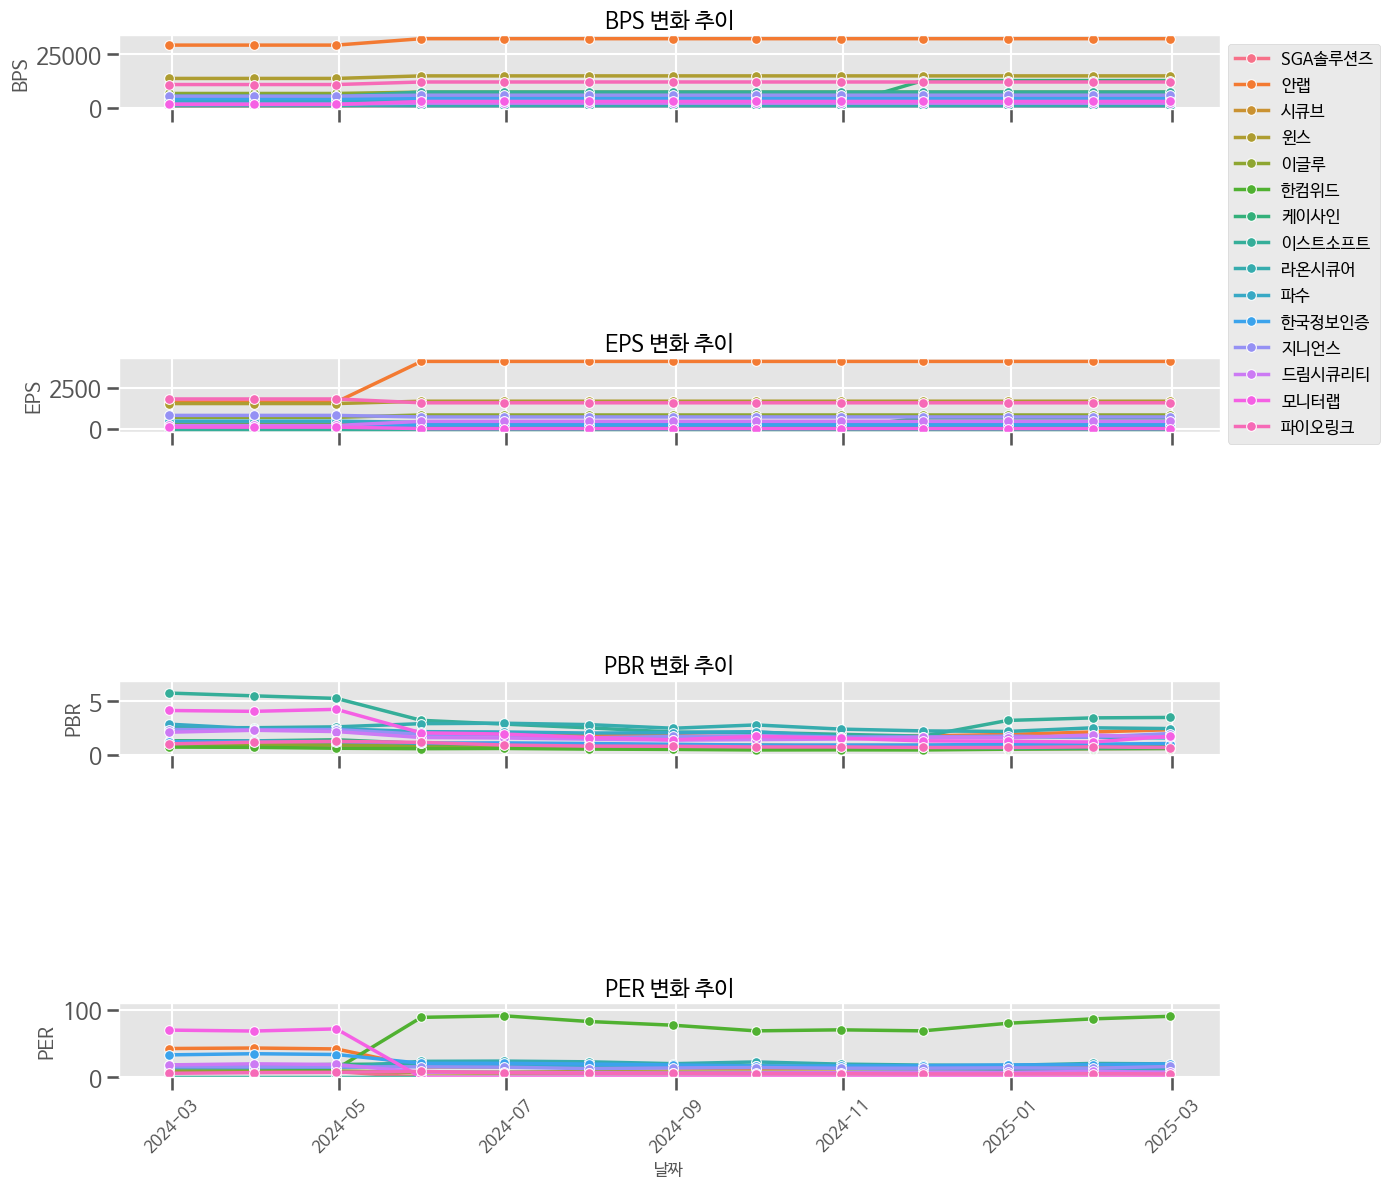

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ 데이터프레임 불러오기 (df가 기존의 피벗 테이블 형태로 되어 있다고 가정)
df_plot = table.reset_index()  # 인덱스를 컬럼으로 변환

# ✅ 그래프 스타일 설정
sns.set_context("talk")  # 전체 폰트 크기 증가
plt.style.use("ggplot")

# ✅ 시각화할 지표 선택 (BPS, EPS, PBR, PER)
metrics = ["BPS", "EPS", "PBR", "PER"]

# ✅ 각 회사별로 그래프를 생성 (멀티 서브플롯)
fig, axes = plt.subplots(len(metrics), 1, figsize=(14, 12), sharex=True)  # 🔹 그래프 크기 키움

for idx, metric in enumerate(metrics):
    sns.lineplot(
        data=df_plot, x="날짜", y=metric, hue="회사명", ax=axes[idx],
        marker="o", linewidth=2.5, markersize=7  # 🔹 선과 마커 크기 증가
    )
    axes[idx].set_title(f"{metric} 변화 추이", fontsize=16)  # 🔹 제목 크기 증가
    axes[idx].set_ylabel(metric, fontsize=14)  # 🔹 Y축 라벨 크기 증가

    # 🔹 필요하면 특정 지표의 축 범위 조정 (예: PBR, PER가 너무 크거나 작을 경우)
    if metric in ["PBR", "PER"]:
        axes[idx].set_ylim(0, df_plot[metric].max() * 1.2)  # 최대값보다 약간 크게 설정

    if idx == 0:
        axes[idx].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)  # 첫 번째 그래프에만 범례 표시
    else:
        axes[idx].get_legend().remove()  # 나머지 그래프에서는 범례 제거

plt.xticks(rotation=45, fontsize=12)  # 🔹 X축 글씨 크기 조정
plt.tight_layout()
plt.show()
